# Importing Libraries 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cv2

# Loading Data  

In [3]:
def load_data(base_dir):
    data = []
    labels = []
    
    for label in os.listdir(base_dir):
        for img in os.listdir(os.path.join(base_dir, label)):
            img_path = os.path.join(base_dir, label, img)
            data.append(img_path)
            labels.append(label)
    
    return pd.DataFrame({'image': data, 'label': labels})

train_df = load_data(r'C:\Users\arshi\OneDrive\Desktop\College\4th year\MLH\File\chest_xray\train')
val_df = load_data(r'C:\Users\arshi\OneDrive\Desktop\College\4th year\MLH\File\chest_xray\val')
test_df = load_data(r'C:\Users\arshi\OneDrive\Desktop\College\4th year\MLH\File\chest_xray\test')

# Exploratory Data Analysis 

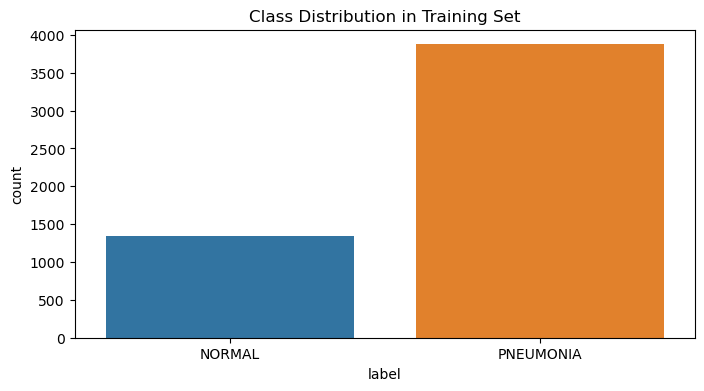

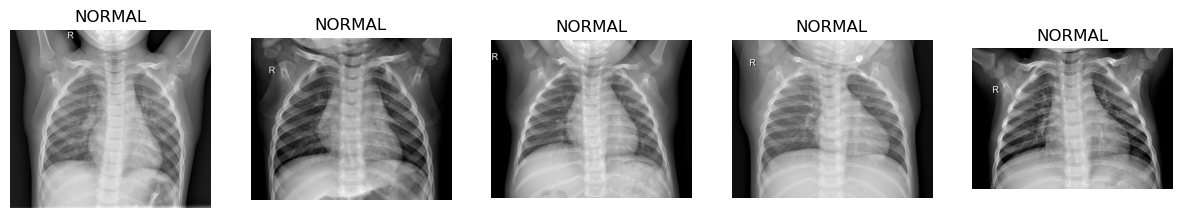

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Set')
plt.show()

# Sample images
def display_samples(dataframe, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_path = dataframe['image'].iloc[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(dataframe['label'].iloc[i])
    plt.show()

display_samples(train_df)

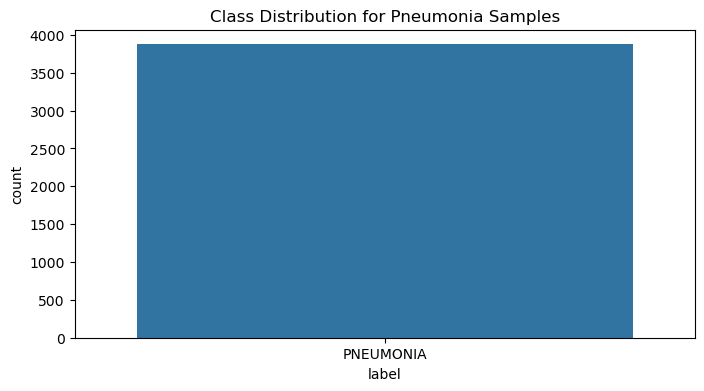

In [5]:
# Filter the DataFrame for pneumonia samples
pneumonia_df = train_df[train_df['label'] == 'PNEUMONIA']

# Visualize class distribution for pneumonia vs. normal
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=pneumonia_df)
plt.title('Class Distribution for Pneumonia Samples')
plt.show()


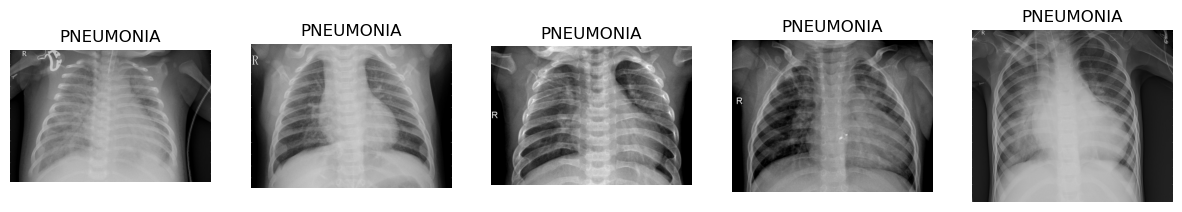

In [6]:
# Display sample pneumonia images
display_samples(pneumonia_df, num_samples=5)

# Data Preprocessing 

In [7]:
IMG_SIZE = (150, 150)

def preprocess_images(dataframe):
    images = []
    for img_path in dataframe['image']:
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalize
        images.append(img)
    return np.array(images)

X_train = preprocess_images(train_df)
y_train = pd.get_dummies(train_df['label']).values

X_val = preprocess_images(val_df)
y_val = pd.get_dummies(val_df['label']).values

X_test = preprocess_images(test_df)
y_test = pd.get_dummies(test_df['label']).values

# Data Augmentation 

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# CNN Model Building 

In [9]:
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(150, 150, 3)),  # Define the input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,610 (18.42 MB)

 Trainable params: 4,828,610 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model 

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[early_stopping])

Epoch 1/20


C:\Users\arshi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 865ms/step - accuracy: 0.7222 - loss: 0.6013 - val_accuracy: 0.6250 - val_loss: 0.6656
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 777ms/step - accuracy: 0.8366 - loss: 0.3503 - val_accuracy: 0.8125 - val_loss: 0.4608
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 776ms/step - accuracy: 0.8668 - loss: 0.3169 - val_accuracy: 0.8750 - val_loss: 0.4033
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 837ms/step - accuracy: 0.8760 - loss: 0.2774 - val_accuracy: 0.7500 - val_loss: 0.5818
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 813ms/step - accuracy: 0.8883 - loss: 0.2594 - val_accuracy: 0.7500 - val_loss: 0.7948
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 778ms/step - accuracy: 0.8935 - loss: 0.2463 - val_accuracy: 0.8750 - val_loss: 0.2945
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 768ms/step - accuracy: 0.8932 - loss: 0.2505 - val_accuracy: 0.8750 - val_loss: 0.4005
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 784ms/step - accuracy: 0.9074 - loss: 0.23

# Plotting Training History 

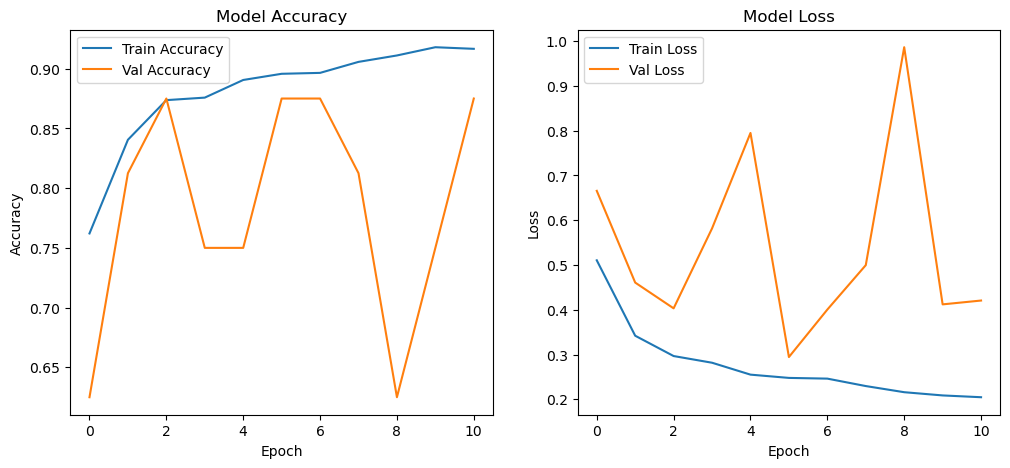

In [13]:
def plot_training_history(history):
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)

# Evaluation 

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.8715 - loss: 0.3700
Test Accuracy: 0.8990
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       234
           1       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



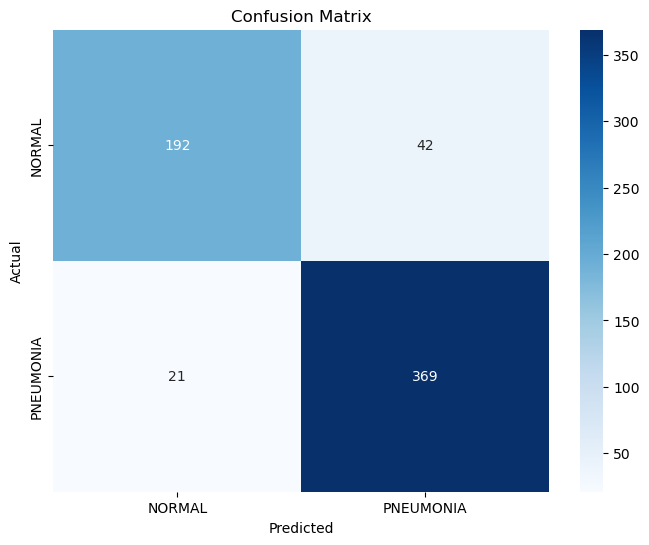

In [14]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'], 
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Healthcare Evaluation Metrics 

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Get Predictions
y_pred_prob = model.predict(X_test)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True labels in the test set

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step


In [30]:
# Calculate Metrics
# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8990


In [31]:
# Precision (Positive Predictive Value - PPV)
ppv = precision_score(y_true, y_pred_classes)
print(f'Precision (PPV): {ppv:.4f}')

Precision (PPV): 0.8978


In [32]:
# Recall (Sensitivity)
sensitivity = recall_score(y_true, y_pred_classes)
print(f'Recall (Sensitivity): {sensitivity:.4f}')

Recall (Sensitivity): 0.9462


In [33]:
# F1 Score
f1 = f1_score(y_true, y_pred_classes)
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9213


In [34]:
# F2 Score
f2 = f1_score(y_true, y_pred_classes)
print(f'F2 Score: {f2:.4f}')

F2 Score: 0.9213


In [35]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

In [36]:
conf_matrix

array([[192,  42],
       [ 21, 369]], dtype=int64)

In [37]:
# Specificity (True Negative Rate)
specificity = tn / (tn + fp)
print(f'Specificity: {specificity:.4f}')

Specificity: 0.8205


In [38]:
# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print(f'Negative Predictive Value (NPV): {npv:.4f}')

Negative Predictive Value (NPV): 0.9014


In [39]:
# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred_classes)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

Matthews Correlation Coefficient (MCC): 0.7828


In [40]:
# Diagnostic Odds Ratio (DOR)
dor = (sensitivity * specificity) / ((1 - sensitivity) * (1 - specificity))
print(f'Diagnostic Odds Ratio (DOR): {dor:.4f}')

Diagnostic Odds Ratio (DOR): 80.3265


In [41]:
# AUC-ROC
roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])  # Use the positive class probability for AUC-ROC
print(f'AUC-ROC: {roc_auc:.4f}')

AUC-ROC: 0.9582


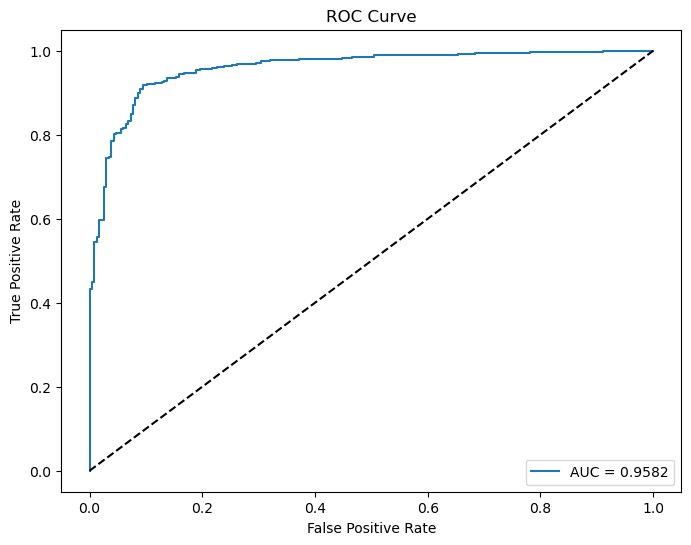

In [42]:
#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

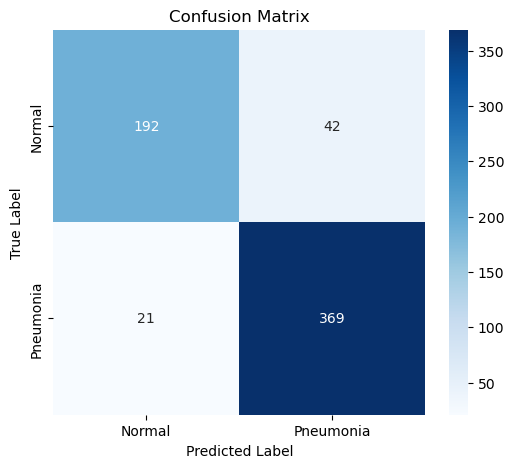

In [43]:
# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()